The task of recovering a high resolution (HR) image from its low resolution counterpart is commonly referred to as Single Image Super Resolution (SISR). 

The model implemented here is ESPCN ([Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158)) and we are going to use TensorFlow Lite to run inference on the trained model.

## Setup

We are going to need to do some color space transformation, so let's install OpenCV first.

In [1]:
!pip install opencv-python

Import dependencies.

In [2]:
import tensorflow as tf
import tarfile
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Conv2D, Input, Lambda, Activation
from tensorflow.python.keras.models import Model
from os.path import exists, join, basename
from os import makedirs, remove, path
from six.moves import urllib

Set some parameters and download BSD300 dataset.

In [3]:
SCALE = 3
LR_SIZE = 100
# Make sure HR_SIZE is smaller than 300 since some images in the dataset have height/width < 300
HR_SIZE = LR_SIZE * SCALE

BATCH_SIZE = 100

def download_dataset(file, target_dir="dataset", extract=True):
    if not exists(join(target_dir, "BSDS300/images")):
        source_url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        target_dir = path.abspath(target_dir)
        tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)

download_dataset('BSDS300-images.tgz')

TRAIN_IMAGES = "dataset/BSDS300/images/train/*.jpg"  
TEST_IMAGES = "dataset/BSDS300/images/test/*.jpg"

22216704/22211847 [==============================] - 9s 0us/step


ESPCN implements a simple network with 3 convolutional layers and 1 pixel shuffle layer on the Y channel (luminance) in the YCbCr color space. Cb and Cr channels are upsampled using bicubic method. We can prepare our training and test datasets as the following.

In [4]:
def extract_luminance(path):
    img = cv2.imread(path.numpy().decode('UTF8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Extract luminance
    img_y = img[:, :, 0:1]
    return img_y

def load_image(img_path):
    [hr_img,] = tf.py_function(extract_luminance, [img_path], [tf.float32])
    hr_img = tf.convert_to_tensor(hr_img)
    hr_img = tf.image.random_crop(hr_img, [HR_SIZE, HR_SIZE, 1])
    hr_img = tf.cast(hr_img, tf.float32)
    hr_img = hr_img / 255.
    lr_img = tf.image.resize(hr_img, [HR_SIZE//SCALE, HR_SIZE//SCALE], tf.image.ResizeMethod.BICUBIC)
    return lr_img, hr_img

training_dataset = tf.data.Dataset.list_files(TRAIN_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE) \
                   .shuffle(buffer_size = 200) 

test_dataset = tf.data.Dataset.list_files(TEST_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE)

## Build the model

In [5]:
# Helper function to wrap depth_to_space op (pixel shuffle) in a Lambda layer
def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

input = Input(shape=(LR_SIZE, LR_SIZE, 1))
x = Conv2D(64, [5, 5], padding='same', activation='relu')(input)
x = Conv2D(32, [3, 3], padding='same', activation='relu')(x)
x = Conv2D(SCALE**2, [3, 3], padding='same')(x)
x = Lambda(pixel_shuffle(scale=SCALE))(x)
x = Activation('tanh')(x)
model = Model(input, x, name="ESPCN")

logdir = "./logdir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MSE)

model.summary()

Model: "ESPCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 9)       2601      
_________________________________________________________________
lambda (Lambda)              (None, 300, 300, 1)       0         
_________________________________________________________________
activation (Activation)      (None, 300, 300, 1)       0         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________

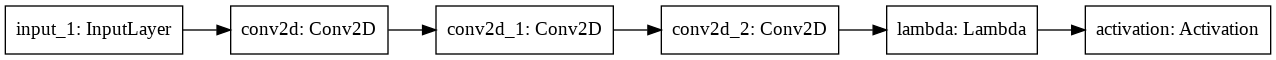

In [6]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

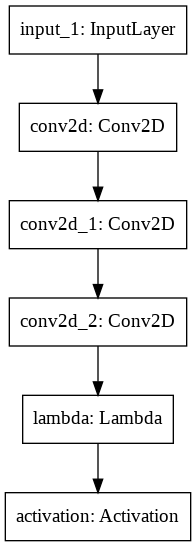

In [7]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, expand_nested=False, dpi=96
)

## Train and export the model

In [8]:
model.fit(training_dataset,epochs= 700,validation_data=test_dataset,
                    callbacks = [tensorboard_callback],workers = 4)

model.save("export")

Epoch 1/700
2/2 [==============================] - 9s 744ms/step - loss: 0.2093 - val_loss: 0.2013
Epoch 2/700
2/2 [==============================] - 1s 447ms/step - loss: 0.1969 - val_loss: 0.1960
Epoch 3/700
2/2 [==============================] - 1s 449ms/step - loss: 0.1930 - val_loss: 0.1837
Epoch 4/700
2/2 [==============================] - 1s 443ms/step - loss: 0.1812 - val_loss: 0.1763
Epoch 5/700
2/2 [==============================] - 1s 452ms/step - loss: 0.1720 - val_loss: 0.1682
Epoch 6/700
2/2 [==============================] - 1s 458ms/step - loss: 0.1673 - val_loss: 0.1587
Epoch 7/700
2/2 [==============================] - 1s 443ms/step - loss: 0.1551 - val_loss: 0.1503
Epoch 8/700
2/2 [==============================] - 1s 444ms/step - loss: 0.1479 - val_loss: 0.1460
Epoch 9/700
2/2 [==============================] - 1s 452ms/step - loss: 0.1434 - val_loss: 0.1359
Epoch 10/700
2/2 [==============================] - 1s 447ms/step - loss: 0.1357 - val_loss: 0.1287
Epoch 11/

## Super resolve a test low resolution image using TensorFlow Lite.

In [9]:
def load_test_image(img_path):
    hr = cv2.imread(img_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2YCrCb)
    hr = tf.image.crop_to_bounding_box(hr, 0, 0, HR_SIZE, HR_SIZE)
    lr = tf.image.resize(hr, [HR_SIZE//SCALE, HR_SIZE//SCALE])
    lr = tf.cast(lr, tf.uint8)
    return lr, hr

def super_resolve(original_img_path):
    # lr - low resolution image
    # hr - high resolution image (cropped from original)
    # sr - super resolved image from lr
    lr, hr = load_test_image(original_img_path)
    lr_ycrcb = lr.numpy().copy()    
    lr = cv2.cvtColor(lr.numpy(), cv2.COLOR_YCrCb2RGB)
    hr = cv2.cvtColor(hr.numpy(), cv2.COLOR_YCrCb2RGB)   
    lr_ycrcb = tf.cast(lr_ycrcb, tf.float32)
    lr_y = lr_ycrcb[:, :, 0:1] / 255.
    lr_cr = lr_ycrcb[:, :, 1:2]
    lr_cb = lr_ycrcb[:, :, 2:3]
    lr_y = tf.expand_dims(lr_y, axis=0)
    
    # Use TFLite to super resolve luminance
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], lr_y)
    interpreter.invoke()
    sr_y = interpreter.get_tensor(output_details[0]['index'])
    open("ESPCN.tflite", 'wb').write(tflite_model)
    
    # Transform super resolved image back into RGB color space
    sr_y = sr_y * 255
    sr_cr = tf.image.resize(lr_cr, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr_cb = tf.image.resize(lr_cb, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr = tf.concat([sr_y[0], sr_cr, sr_cb], axis=2)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    sr = cv2.cvtColor(sr.numpy(), cv2.COLOR_YCrCb2RGB)
    return lr, sr, hr

# test_img_path = "dataset/BSDS300/images/test/170057.jpg"
test_img_path = "dataset/BSDS300/images/test/302008.jpg"
lr, sr, hr = super_resolve(test_img_path)

INFO:tensorflow:Assets written to: /tmp/tmpnre0pgv_/assets


## Visualize the result

PSNR ([Peak Signal-to-Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) is a commonly used metric to measure the image recovery quality.

PSNR of super resolved image: %f 29.106602


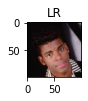

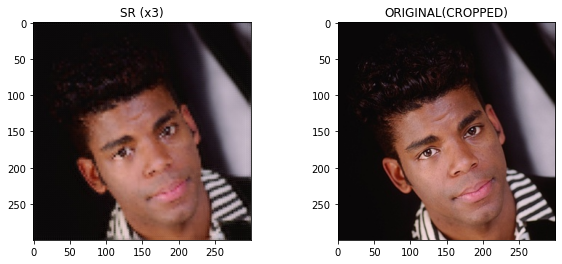

In [10]:
print("PSNR of super resolved image: %f", tf.image.psnr(sr, hr, 255).numpy())  

plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr);


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'SR (x{SCALE})')
plt.imshow(sr);


plt.subplot(1, 2, 2)   
plt.title('ORIGINAL(CROPPED)')
plt.imshow(hr);

## Check the PSNR for the entire test set

In [11]:
import os
test_directory = 'dataset/BSDS300/images/test/'
psnr_list = []
for file in os.listdir(test_directory):
    print(file)
    lr, sr, hr = super_resolve(os.path.join(test_directory + file))
    psnr = tf.image.psnr(sr, hr, 255).numpy()
    print('PSNR:', psnr)
    psnr_list.append(psnr)
    
print('Average PSNR for the test set: ', np.mean(psnr_list))

219090.jpg
INFO:tensorflow:Assets written to: /tmp/tmprd10andc/assets


INFO:tensorflow:Assets written to: /tmp/tmprd10andc/assets


PSNR: 23.597357
296059.jpg
INFO:tensorflow:Assets written to: /tmp/tmpwrpgowli/assets


INFO:tensorflow:Assets written to: /tmp/tmpwrpgowli/assets


PSNR: 27.965336
229036.jpg
INFO:tensorflow:Assets written to: /tmp/tmpnkhm08h2/assets


INFO:tensorflow:Assets written to: /tmp/tmpnkhm08h2/assets


PSNR: 20.313387
103070.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8kde6by2/assets


INFO:tensorflow:Assets written to: /tmp/tmp8kde6by2/assets


PSNR: 26.93821
45096.jpg
INFO:tensorflow:Assets written to: /tmp/tmpp7dghpzm/assets


INFO:tensorflow:Assets written to: /tmp/tmpp7dghpzm/assets


PSNR: 30.320574
148026.jpg
INFO:tensorflow:Assets written to: /tmp/tmpk9o9qrz_/assets


INFO:tensorflow:Assets written to: /tmp/tmpk9o9qrz_/assets


PSNR: 18.833908
163085.jpg
INFO:tensorflow:Assets written to: /tmp/tmpl36kisng/assets


INFO:tensorflow:Assets written to: /tmp/tmpl36kisng/assets


PSNR: 27.017345
236037.jpg
INFO:tensorflow:Assets written to: /tmp/tmppz3ypcpf/assets


INFO:tensorflow:Assets written to: /tmp/tmppz3ypcpf/assets


PSNR: 22.687662
271035.jpg
INFO:tensorflow:Assets written to: /tmp/tmpwn3z435d/assets


INFO:tensorflow:Assets written to: /tmp/tmpwn3z435d/assets


PSNR: 23.747517
86016.jpg
INFO:tensorflow:Assets written to: /tmp/tmpg48d1cpp/assets


INFO:tensorflow:Assets written to: /tmp/tmpg48d1cpp/assets


PSNR: 20.159733
3096.jpg
INFO:tensorflow:Assets written to: /tmp/tmpmdi_385t/assets


INFO:tensorflow:Assets written to: /tmp/tmpmdi_385t/assets


PSNR: 35.460262
291000.jpg
INFO:tensorflow:Assets written to: /tmp/tmpa8w4bnz1/assets


INFO:tensorflow:Assets written to: /tmp/tmpa8w4bnz1/assets


PSNR: 19.047691
167083.jpg
INFO:tensorflow:Assets written to: /tmp/tmpaew701d4/assets


INFO:tensorflow:Assets written to: /tmp/tmpaew701d4/assets


PSNR: 16.937542
38092.jpg
INFO:tensorflow:Assets written to: /tmp/tmpbpflzg4a/assets


INFO:tensorflow:Assets written to: /tmp/tmpbpflzg4a/assets


PSNR: 23.309351
76053.jpg
INFO:tensorflow:Assets written to: /tmp/tmpz7hz_2kg/assets


INFO:tensorflow:Assets written to: /tmp/tmpz7hz_2kg/assets


PSNR: 26.65475
8023.jpg
INFO:tensorflow:Assets written to: /tmp/tmpy5pc1cva/assets


INFO:tensorflow:Assets written to: /tmp/tmpy5pc1cva/assets


PSNR: 26.502653
58060.jpg
INFO:tensorflow:Assets written to: /tmp/tmpj_lyzwt3/assets


INFO:tensorflow:Assets written to: /tmp/tmpj_lyzwt3/assets


PSNR: 18.22748
14037.jpg
INFO:tensorflow:Assets written to: /tmp/tmpofud7v8s/assets


INFO:tensorflow:Assets written to: /tmp/tmpofud7v8s/assets


PSNR: 29.610147
306005.jpg
INFO:tensorflow:Assets written to: /tmp/tmpj28j7w_k/assets


INFO:tensorflow:Assets written to: /tmp/tmpj28j7w_k/assets


PSNR: 24.39427
134035.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8y9hqcwv/assets


INFO:tensorflow:Assets written to: /tmp/tmp8y9hqcwv/assets


PSNR: 20.527275
37073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpob82i4wy/assets


INFO:tensorflow:Assets written to: /tmp/tmpob82i4wy/assets


PSNR: 26.709574
300091.jpg
INFO:tensorflow:Assets written to: /tmp/tmpemdv_to8/assets


INFO:tensorflow:Assets written to: /tmp/tmpemdv_to8/assets


PSNR: 26.236128
21077.jpg
INFO:tensorflow:Assets written to: /tmp/tmpnkttgrby/assets


INFO:tensorflow:Assets written to: /tmp/tmpnkttgrby/assets


PSNR: 23.094309
253055.jpg
INFO:tensorflow:Assets written to: /tmp/tmps9mo2f0e/assets


INFO:tensorflow:Assets written to: /tmp/tmps9mo2f0e/assets


PSNR: 24.417019
24077.jpg
INFO:tensorflow:Assets written to: /tmp/tmpx_8nvkgi/assets


INFO:tensorflow:Assets written to: /tmp/tmpx_8nvkgi/assets


PSNR: 20.625463
42012.jpg
INFO:tensorflow:Assets written to: /tmp/tmpwo2meey4/assets


INFO:tensorflow:Assets written to: /tmp/tmpwo2meey4/assets


PSNR: 28.50316
123074.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7_q5sbqm/assets


INFO:tensorflow:Assets written to: /tmp/tmp7_q5sbqm/assets


PSNR: 26.964972
285079.jpg
INFO:tensorflow:Assets written to: /tmp/tmp5f64hny4/assets


INFO:tensorflow:Assets written to: /tmp/tmp5f64hny4/assets


PSNR: 22.20365
189080.jpg
INFO:tensorflow:Assets written to: /tmp/tmptjovabi_/assets


INFO:tensorflow:Assets written to: /tmp/tmptjovabi_/assets


PSNR: 27.297129
85048.jpg
INFO:tensorflow:Assets written to: /tmp/tmpp1lng17h/assets


INFO:tensorflow:Assets written to: /tmp/tmpp1lng17h/assets


PSNR: 22.600937
156065.jpg
INFO:tensorflow:Assets written to: /tmp/tmpt9b1txy9/assets


INFO:tensorflow:Assets written to: /tmp/tmpt9b1txy9/assets


PSNR: 23.604158
216081.jpg
INFO:tensorflow:Assets written to: /tmp/tmpvuiwyacj/assets


INFO:tensorflow:Assets written to: /tmp/tmpvuiwyacj/assets


PSNR: 22.747091
101085.jpg
INFO:tensorflow:Assets written to: /tmp/tmp99pq2q4b/assets


INFO:tensorflow:Assets written to: /tmp/tmp99pq2q4b/assets


PSNR: 22.250578
19021.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7u3x72c9/assets


INFO:tensorflow:Assets written to: /tmp/tmp7u3x72c9/assets


PSNR: 24.322834
304074.jpg
INFO:tensorflow:Assets written to: /tmp/tmpyhc__74u/assets


INFO:tensorflow:Assets written to: /tmp/tmpyhc__74u/assets


PSNR: 23.405167
385039.jpg
INFO:tensorflow:Assets written to: /tmp/tmprqaj_sxs/assets


INFO:tensorflow:Assets written to: /tmp/tmprqaj_sxs/assets


PSNR: 20.395826
223061.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_morcpyx/assets


INFO:tensorflow:Assets written to: /tmp/tmp_morcpyx/assets


PSNR: 22.007
97033.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_6jsbwhr/assets


INFO:tensorflow:Assets written to: /tmp/tmp_6jsbwhr/assets


PSNR: 21.543884
351093.jpg
INFO:tensorflow:Assets written to: /tmp/tmp1da_076q/assets


INFO:tensorflow:Assets written to: /tmp/tmp1da_076q/assets


PSNR: 19.331554
160068.jpg
INFO:tensorflow:Assets written to: /tmp/tmpmnpojfas/assets


INFO:tensorflow:Assets written to: /tmp/tmpmnpojfas/assets


PSNR: 23.521385
108082.jpg
INFO:tensorflow:Assets written to: /tmp/tmpy3ri8kx3/assets


INFO:tensorflow:Assets written to: /tmp/tmpy3ri8kx3/assets


PSNR: 23.87242
12084.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8v0byyi0/assets


INFO:tensorflow:Assets written to: /tmp/tmp8v0byyi0/assets


PSNR: 25.854923
302008.jpg
INFO:tensorflow:Assets written to: /tmp/tmpsp03dpzs/assets


INFO:tensorflow:Assets written to: /tmp/tmpsp03dpzs/assets


PSNR: 29.106602
69020.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8itibhu0/assets


INFO:tensorflow:Assets written to: /tmp/tmp8itibhu0/assets


PSNR: 24.804815
106024.jpg
INFO:tensorflow:Assets written to: /tmp/tmp9glied_l/assets


INFO:tensorflow:Assets written to: /tmp/tmp9glied_l/assets


PSNR: 25.956062
41033.jpg
INFO:tensorflow:Assets written to: /tmp/tmps94674na/assets


INFO:tensorflow:Assets written to: /tmp/tmps94674na/assets


PSNR: 28.971628
108070.jpg
INFO:tensorflow:Assets written to: /tmp/tmpuazrk1hf/assets


INFO:tensorflow:Assets written to: /tmp/tmpuazrk1hf/assets


PSNR: 21.953653
147091.jpg
INFO:tensorflow:Assets written to: /tmp/tmp08tuonol/assets


INFO:tensorflow:Assets written to: /tmp/tmp08tuonol/assets


PSNR: 22.884924
102061.jpg
INFO:tensorflow:Assets written to: /tmp/tmpbe7qh0ep/assets


INFO:tensorflow:Assets written to: /tmp/tmpbe7qh0ep/assets


PSNR: 21.365211
253027.jpg
INFO:tensorflow:Assets written to: /tmp/tmpj6tvdeu4/assets


INFO:tensorflow:Assets written to: /tmp/tmpj6tvdeu4/assets


PSNR: 19.121012
196073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpp7rehr6q/assets


INFO:tensorflow:Assets written to: /tmp/tmpp7rehr6q/assets


PSNR: 25.193602
62096.jpg
INFO:tensorflow:Assets written to: /tmp/tmp69vs7mk9/assets


INFO:tensorflow:Assets written to: /tmp/tmp69vs7mk9/assets


PSNR: 21.116825
87046.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqyf7cwsd/assets


INFO:tensorflow:Assets written to: /tmp/tmpqyf7cwsd/assets


PSNR: 23.437716
175032.jpg
INFO:tensorflow:Assets written to: /tmp/tmp6f8fvbyc/assets


INFO:tensorflow:Assets written to: /tmp/tmp6f8fvbyc/assets


PSNR: 18.504068
197017.jpg
INFO:tensorflow:Assets written to: /tmp/tmpjxxeovkg/assets


INFO:tensorflow:Assets written to: /tmp/tmpjxxeovkg/assets


PSNR: 25.17656
304034.jpg
INFO:tensorflow:Assets written to: /tmp/tmpjqnqgddk/assets


INFO:tensorflow:Assets written to: /tmp/tmpjqnqgddk/assets


PSNR: 22.959318
65033.jpg
INFO:tensorflow:Assets written to: /tmp/tmp23zpsegt/assets


INFO:tensorflow:Assets written to: /tmp/tmp23zpsegt/assets


PSNR: 22.253057
130026.jpg
INFO:tensorflow:Assets written to: /tmp/tmplg70jnn7/assets


INFO:tensorflow:Assets written to: /tmp/tmplg70jnn7/assets


PSNR: 22.44567
108005.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzfn5su57/assets


INFO:tensorflow:Assets written to: /tmp/tmpzfn5su57/assets


PSNR: 23.397337
69015.jpg
INFO:tensorflow:Assets written to: /tmp/tmpg1sg0wl_/assets


INFO:tensorflow:Assets written to: /tmp/tmpg1sg0wl_/assets


PSNR: 26.672688
54082.jpg
INFO:tensorflow:Assets written to: /tmp/tmpszev6ks6/assets


INFO:tensorflow:Assets written to: /tmp/tmpszev6ks6/assets


PSNR: 25.74155
170057.jpg
INFO:tensorflow:Assets written to: /tmp/tmpplhx2ym4/assets


INFO:tensorflow:Assets written to: /tmp/tmpplhx2ym4/assets


PSNR: 27.795631
86000.jpg
INFO:tensorflow:Assets written to: /tmp/tmpz3vh_5f_/assets


INFO:tensorflow:Assets written to: /tmp/tmpz3vh_5f_/assets


PSNR: 22.049192
296007.jpg
INFO:tensorflow:Assets written to: /tmp/tmpf7phbqh4/assets


INFO:tensorflow:Assets written to: /tmp/tmpf7phbqh4/assets


PSNR: 29.48899
241004.jpg
INFO:tensorflow:Assets written to: /tmp/tmp647urkpv/assets


INFO:tensorflow:Assets written to: /tmp/tmp647urkpv/assets


PSNR: 26.109335
38082.jpg
INFO:tensorflow:Assets written to: /tmp/tmprhcs1h4p/assets


INFO:tensorflow:Assets written to: /tmp/tmprhcs1h4p/assets


PSNR: 24.673227
78004.jpg
INFO:tensorflow:Assets written to: /tmp/tmpy2t4lter/assets


INFO:tensorflow:Assets written to: /tmp/tmpy2t4lter/assets


PSNR: 22.278717
89072.jpg
INFO:tensorflow:Assets written to: /tmp/tmp2886ydv9/assets


INFO:tensorflow:Assets written to: /tmp/tmp2886ydv9/assets


PSNR: 23.763954
33039.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8qcwrjlu/assets


INFO:tensorflow:Assets written to: /tmp/tmp8qcwrjlu/assets


PSNR: 18.10097
220075.jpg
INFO:tensorflow:Assets written to: /tmp/tmpv5tt46w5/assets


INFO:tensorflow:Assets written to: /tmp/tmpv5tt46w5/assets


PSNR: 25.35663
145086.jpg
INFO:tensorflow:Assets written to: /tmp/tmpwg2wu3b1/assets


INFO:tensorflow:Assets written to: /tmp/tmpwg2wu3b1/assets


PSNR: 22.01625
210088.jpg
INFO:tensorflow:Assets written to: /tmp/tmpcd71f32_/assets


INFO:tensorflow:Assets written to: /tmp/tmpcd71f32_/assets


PSNR: 27.90318
182053.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8_pj7plw/assets


INFO:tensorflow:Assets written to: /tmp/tmp8_pj7plw/assets


PSNR: 21.269136
159008.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3431v9kv/assets


INFO:tensorflow:Assets written to: /tmp/tmp3431v9kv/assets


PSNR: 25.441994
109053.jpg
INFO:tensorflow:Assets written to: /tmp/tmpbbxltxk9/assets


INFO:tensorflow:Assets written to: /tmp/tmpbbxltxk9/assets


PSNR: 28.270958
157055.jpg
INFO:tensorflow:Assets written to: /tmp/tmpkvl6vp1x/assets


INFO:tensorflow:Assets written to: /tmp/tmpkvl6vp1x/assets


PSNR: 23.066227
148089.jpg
INFO:tensorflow:Assets written to: /tmp/tmphucz39x5/assets


INFO:tensorflow:Assets written to: /tmp/tmphucz39x5/assets


PSNR: 20.60562
143090.jpg
INFO:tensorflow:Assets written to: /tmp/tmparp0r3h2/assets


INFO:tensorflow:Assets written to: /tmp/tmparp0r3h2/assets


PSNR: 29.506903
208001.jpg
INFO:tensorflow:Assets written to: /tmp/tmpvjnqecal/assets


INFO:tensorflow:Assets written to: /tmp/tmpvjnqecal/assets


PSNR: 26.009626
41069.jpg
INFO:tensorflow:Assets written to: /tmp/tmpd47so5__/assets


INFO:tensorflow:Assets written to: /tmp/tmpd47so5__/assets


PSNR: 22.183414
227092.jpg
INFO:tensorflow:Assets written to: /tmp/tmpiiiscza4/assets


INFO:tensorflow:Assets written to: /tmp/tmpiiiscza4/assets


PSNR: 29.837692
241048.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqdj_rq7n/assets


INFO:tensorflow:Assets written to: /tmp/tmpqdj_rq7n/assets


PSNR: 21.664463
299086.jpg
INFO:tensorflow:Assets written to: /tmp/tmpaosirnct/assets


INFO:tensorflow:Assets written to: /tmp/tmpaosirnct/assets


PSNR: 31.399443
55073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpb5ocwefn/assets


INFO:tensorflow:Assets written to: /tmp/tmpb5ocwefn/assets


PSNR: 18.957249
126007.jpg
INFO:tensorflow:Assets written to: /tmp/tmphc29mztp/assets


INFO:tensorflow:Assets written to: /tmp/tmphc29mztp/assets


PSNR: 26.942387
43074.jpg
INFO:tensorflow:Assets written to: /tmp/tmpfckqmhcv/assets


INFO:tensorflow:Assets written to: /tmp/tmpfckqmhcv/assets


PSNR: 26.930397
175043.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzdg9dkh4/assets


INFO:tensorflow:Assets written to: /tmp/tmpzdg9dkh4/assets


PSNR: 23.041485
376043.jpg
INFO:tensorflow:Assets written to: /tmp/tmpues9n56i/assets


INFO:tensorflow:Assets written to: /tmp/tmpues9n56i/assets


PSNR: 22.290241
295087.jpg
INFO:tensorflow:Assets written to: /tmp/tmposedakax/assets


INFO:tensorflow:Assets written to: /tmp/tmposedakax/assets


PSNR: 25.029657
66053.jpg
INFO:tensorflow:Assets written to: /tmp/tmp4t90q16f/assets


INFO:tensorflow:Assets written to: /tmp/tmp4t90q16f/assets


PSNR: 25.173843
101087.jpg
INFO:tensorflow:Assets written to: /tmp/tmp0qhx85z9/assets


INFO:tensorflow:Assets written to: /tmp/tmp0qhx85z9/assets


PSNR: 21.372946
42049.jpg
INFO:tensorflow:Assets written to: /tmp/tmpm28ccqga/assets


INFO:tensorflow:Assets written to: /tmp/tmpm28ccqga/assets


PSNR: 25.556227
105025.jpg
INFO:tensorflow:Assets written to: /tmp/tmpa_8bx844/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_8bx844/assets


PSNR: 22.57708
260058.jpg
INFO:tensorflow:Assets written to: /tmp/tmpemorf14f/assets


INFO:tensorflow:Assets written to: /tmp/tmpemorf14f/assets


PSNR: 30.044872
69040.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7wi_gn19/assets


INFO:tensorflow:Assets written to: /tmp/tmp7wi_gn19/assets


PSNR: 22.867676
86068.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3bchq14b/assets


INFO:tensorflow:Assets written to: /tmp/tmp3bchq14b/assets


PSNR: 24.147388
119082.jpg
INFO:tensorflow:Assets written to: /tmp/tmpwupqsd_0/assets


INFO:tensorflow:Assets written to: /tmp/tmpwupqsd_0/assets


PSNR: 20.520018
167062.jpg
INFO:tensorflow:Assets written to: /tmp/tmp1njdo26t/assets


INFO:tensorflow:Assets written to: /tmp/tmp1njdo26t/assets


PSNR: 23.239202
16077.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3gai44xy/assets


INFO:tensorflow:Assets written to: /tmp/tmp3gai44xy/assets


PSNR: 24.047924
361010.jpg
INFO:tensorflow:Assets written to: /tmp/tmp1i55o02l/assets


INFO:tensorflow:Assets written to: /tmp/tmp1i55o02l/assets


PSNR: 25.160685
Average PSNR for the test set:  24.115147
